In [1]:
import os
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
from shutil import copyfile, move
from ignite.metrics import Accuracy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print(os.listdir("/kaggle/input/skin-cancer-mnist-ham10000/"))

['hmnist_8_8_RGB.csv', 'hmnist_28_28_RGB.csv', 'HAM10000_images_part_1', 'ham10000_images_part_1', 'hmnist_8_8_L.csv', 'HAM10000_images_part_2', 'ham10000_images_part_2', 'hmnist_28_28_L.csv', 'HAM10000_metadata.csv']


In [3]:
data = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

<Axes: title={'center': 'localization'}, xlabel='localization', ylabel='Count'>

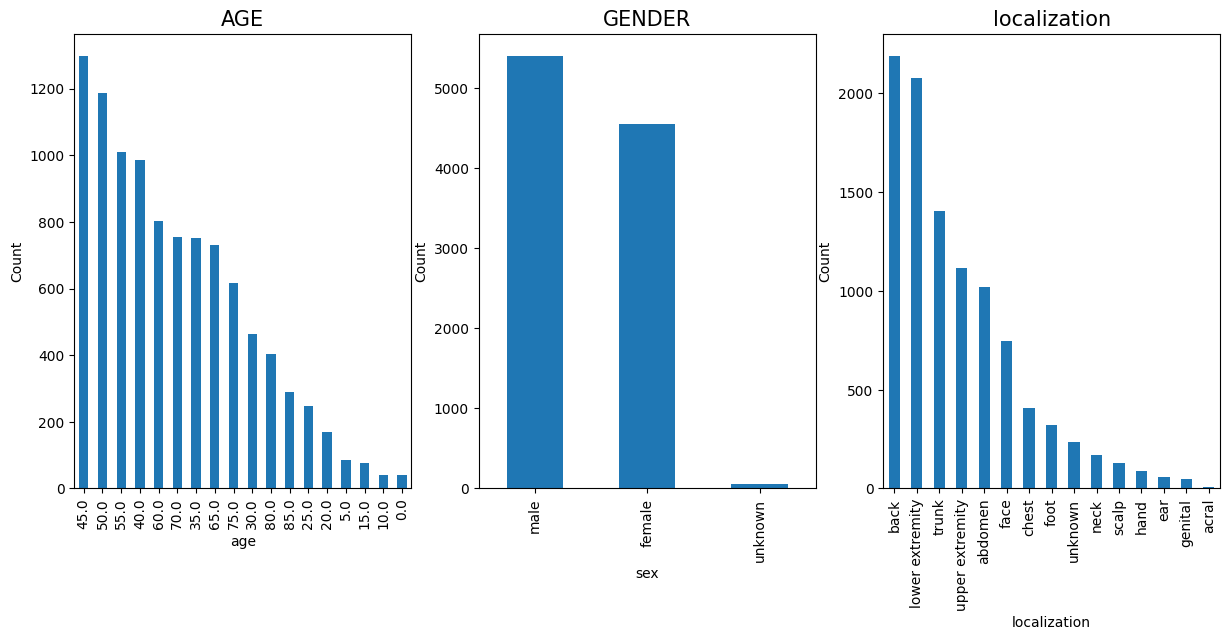

In [4]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(left=0.125, bottom=1, right=0.9, top=2, hspace=0.2)
plt.subplot(2,4,1)
plt.title("AGE",fontsize=15)
plt.ylabel("Count")
data['age'].value_counts().plot.bar()

plt.subplot(2,4,2)
plt.title("GENDER",fontsize=15)
plt.ylabel("Count")
data['sex'].value_counts().plot.bar()

plt.subplot(2,4,3)
plt.title("localization",fontsize=15)
plt.ylabel("Count")
plt.xticks(rotation=45)
data['localization'].value_counts().plot.bar()

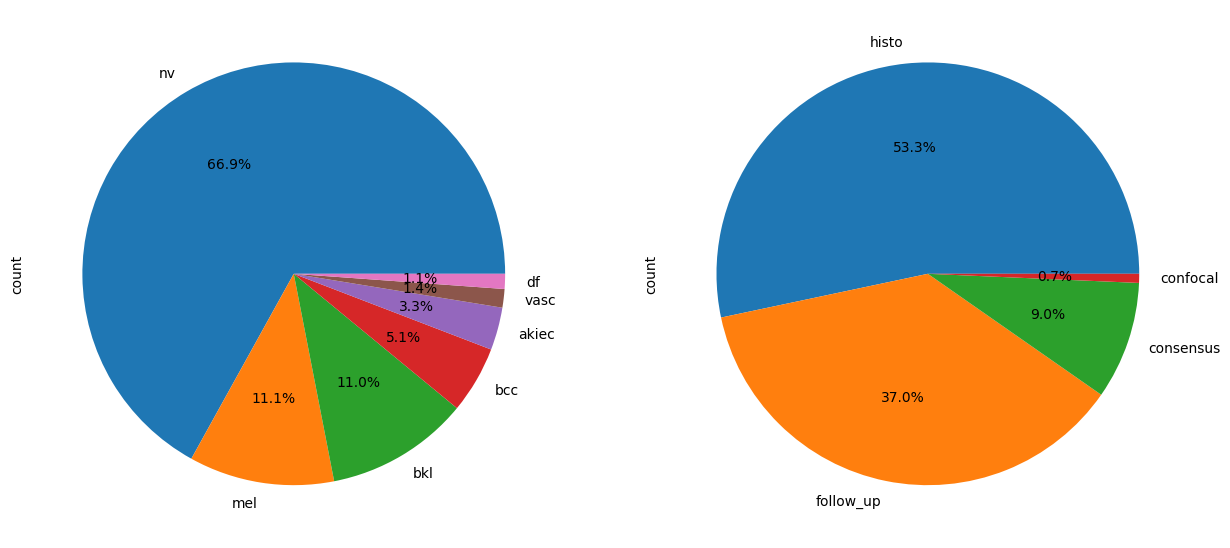

In [5]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
data['dx'].value_counts().plot.pie(autopct="%1.1f%%")
plt.subplot(1,2,2)
data['dx_type'].value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

In [6]:
data['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [7]:
!pip install barbar pytorch-ignite

In [8]:
pip install -q torch-summary

Note: you may need to restart the kernel to use updated packages.


In [9]:
from torchvision import transforms, datasets
import torch
import torch.nn as nn
import torchvision
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from barbar import Bar

In [10]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when monitored metric decrease.'''
        if self.verbose:
            self.trace_func(f'Monitored metric has improved ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
#         torch.save(model.state_dict(), f'/kaggle/working/skin_models/skinmodel50.pt') 

        torch.save(model.state_dict(), f'/kaggle/working/skin_models/{self.path}') 
        self.val_loss_min = val_loss


In [11]:
def split_data(source, training,test, split_size):    
    files = []
    for filename in os.listdir(source):
        file = source + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * split_size)
    test_length = int(len(files) - training_length)
#     validation_length = int(training_length*0.1)
#     training_length = int(training_length - validation_length)
    
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
#     validation_set = shuffled_set[training_length:training_length+validation_length]
    
    test_set = shuffled_set[training_length:]
    
    for filename in training_set:
        this_file = source + filename
        destination = training + filename
        copyfile(this_file, destination)

#     for filename in validation_set:
#         this_file = source + filename
#         destination = validation + filename
#         copyfile(this_file, destination)
        
    for filename in test_set:
        this_file = source + filename
        destination = test + filename
        copyfile(this_file, destination)

In [12]:
os.mkdir('/kaggle/working/skin_models/')

In [13]:
os.mkdir('/kaggle/working/orig/')
os.mkdir('/kaggle/working/orig/0.MEL/')
os.mkdir('/kaggle/working/orig/1.NV/')
os.mkdir('/kaggle/working/orig/2.BCC/')
os.mkdir('/kaggle/working/orig/3.AKIEC/')
os.mkdir('/kaggle/working/orig/4.BKL/')
os.mkdir('/kaggle/working/orig/5.DF/')
os.mkdir('/kaggle/working/orig/6.VASC/')

os.mkdir('/kaggle/working/skin/')
os.mkdir('/kaggle/working/skin/training/')
os.mkdir('/kaggle/working/skin/test/')
# os.mkdir('/kaggle/working/skin/validation/')
os.mkdir('/kaggle/working/skin/training/0.MEL/')
os.mkdir('/kaggle/working/skin/training/1.NV/')
os.mkdir('/kaggle/working/skin/training/2.BCC/')
os.mkdir('/kaggle/working/skin/training/3.AKIEC/')
os.mkdir('/kaggle/working/skin/training/4.BKL/')
os.mkdir('/kaggle/working/skin/training/5.DF/')
os.mkdir('/kaggle/working/skin/training/6.VASC/')
# os.mkdir('/kaggle/working/skin/validation/0.MEL/')
# os.mkdir('/kaggle/working/skin/validation/1.NV/')
# os.mkdir('/kaggle/working/skin/validation/2.BCC/')
# os.mkdir('/kaggle/working/skin/validation/3.AKIEC/')
# os.mkdir('/kaggle/working/skin/validation/4.BKL/')
# os.mkdir('/kaggle/working/skin/validation/5.DF/')
# os.mkdir('/kaggle/working/skin/validation/6.VASC/')

os.mkdir('/kaggle/working/skin/test/0.MEL/')
os.mkdir('/kaggle/working/skin/test/1.NV/')
os.mkdir('/kaggle/working/skin/test/2.BCC/')
os.mkdir('/kaggle/working/skin/test/3.AKIEC/')
os.mkdir('/kaggle/working/skin/test/4.BKL/')
os.mkdir('/kaggle/working/skin/test/5.DF/')
os.mkdir('/kaggle/working/skin/test/6.VASC/')

In [14]:
orig_all = '/kaggle/working/HAM10000/'
source_MEL = '/kaggle/working/orig/0.MEL/'
source_NV = '/kaggle/working/orig/1.NV/'
source_BCC = '/kaggle/working/orig/2.BCC/'
source_AKIEC = '/kaggle/working/orig/3.AKIEC/'
source_BKL = '/kaggle/working/orig/4.BKL/'
source_DF = '/kaggle/working/orig/5.DF/'
source_VASC = '/kaggle/working/orig/6.VASC/'

training_MEL = '/kaggle/working/skin/training/0.MEL/'
training_NV = '/kaggle/working/skin/training/1.NV/'
training_BCC = '/kaggle/working/skin/training/2.BCC/'
training_AKIEC = '/kaggle/working/skin/training/3.AKIEC/'
training_BKL = '/kaggle/working/skin/training/4.BKL/'
training_DF = '/kaggle/working/skin/training/5.DF/'
training_VASC = '/kaggle/working/skin/training/6.VASC/'
# validation_MEL = '/kaggle/working/skin/validation/0.MEL/'
# validation_NV = '/kaggle/working/skin/validation/1.NV/'
# validation_BCC = '/kaggle/working/skin/validation/2.BCC/'
# validation_AKIEC = '/kaggle/working/skin/validation/3.AKIEC/'
# validation_BKL = '/kaggle/working/skin/validation/4.BKL/'
# validation_DF = '/kaggle/working/skin/validation/5.DF/'
# validation_VASC = '/kaggle/working/skin/validation/6.VASC/'

test_MEL = '/kaggle/working/skin/test/0.MEL/'
test_NV = '/kaggle/working/skin/test/1.NV/'
test_BCC = '/kaggle/working/skin/test/2.BCC/'
test_AKIEC = '/kaggle/working/skin/test/3.AKIEC/'
test_BKL = '/kaggle/working/skin/test/4.BKL/'
test_DF = '/kaggle/working/skin/test/5.DF/'
test_VASC = '/kaggle/working/skin/test/6.VASC/'

In [15]:
os.mkdir('/kaggle/working/HAM10000/')

In [16]:
part1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1"
part2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"

for part in [part1,part2]:
    for img in tqdm(os.listdir(part)):
        copyfile(os.path.join(part, img), os.path.join('/kaggle/working/HAM10000/', img))    

100%|██████████| 5015/5015 [00:54<00:00, 91.60it/s] 


In [17]:
data

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [18]:
data.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

In [19]:
len(data)


10015

In [20]:
data = data.drop_duplicates(subset='lesion_id')

In [21]:
len(data)


7470

In [22]:
image_names = [x for x in data['image_id']]
diagnosis = [x for x in data['dx']]

In [23]:
print(len(image_names))
print(len(diagnosis))

7470
7470


In [24]:
print(image_names[0])
print(diagnosis[0])

ISIC_0027419
bkl


In [25]:
pd.unique(data['dx'])

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [26]:
for index, image in tqdm(enumerate(image_names)):
    image = image + '.jpg'
    if diagnosis[index] == 'mel':
        copyfile(os.path.join(orig_all, image), os.path.join(source_MEL, image))
    elif diagnosis[index] == 'nv':
        copyfile(os.path.join(orig_all, image), os.path.join(source_NV, image))
    elif diagnosis[index] == 'bcc': 
        copyfile(os.path.join(orig_all, image), os.path.join(source_BCC, image))
    elif diagnosis[index] == 'akiec': 
        copyfile(os.path.join(orig_all, image), os.path.join(source_AKIEC, image))
    elif diagnosis[index] == 'bkl':
        copyfile(os.path.join(orig_all, image), os.path.join(source_BKL, image))
    elif diagnosis[index] == 'df':  
        copyfile(os.path.join(orig_all, image), os.path.join(source_DF, image))
    elif diagnosis[index] == 'vasc': 
        copyfile(os.path.join(orig_all, image), os.path.join(source_VASC, image))       

7470it [00:02, 3171.59it/s]


In [27]:
# Print amount of pictures for each class
print(len(os.listdir(source_MEL)))
print(len(os.listdir(source_NV)))
print(len(os.listdir(source_BCC)))
print(len(os.listdir(source_AKIEC)))
print(len(os.listdir(source_BKL)))
print(len(os.listdir(source_DF)))
print(len(os.listdir(source_VASC)))

614
5403
327
228
727
73
98


In [28]:
split_size = 0.9
split_data(source_MEL, training_MEL, test_MEL, split_size)
split_data(source_NV, training_NV, test_NV, split_size)
split_data(source_BCC, training_BCC,test_BCC, split_size)
split_data(source_AKIEC, training_AKIEC,test_AKIEC, split_size)
split_data(source_BKL, training_BKL,test_BKL, split_size)
split_data(source_DF, training_DF,test_DF, split_size)
split_data(source_VASC, training_VASC,test_VASC, split_size)

In [29]:
# Print amount of pictures for each class after split, train/val.
print(len(os.listdir(training_MEL)))
print(len(os.listdir(test_MEL)))
# print(len(os.listdir(validation_MEL)))
print(len(os.listdir(training_NV)))
print(len(os.listdir(test_NV)))
# print(len(os.listdir(validation_NV)))
print(len(os.listdir(training_BCC)))
print(len(os.listdir(test_BCC)))
# print(len(os.listdir(validation_BCC)))
print(len(os.listdir(training_AKIEC)))
print(len(os.listdir(test_AKIEC)))
# print(len(os.listdir(validation_AKIEC)))
print(len(os.listdir(training_BKL)))
print(len(os.listdir(test_BKL)))
# print(len(os.listdir(validation_BKL)))
print(len(os.listdir(training_DF)))
print(len(os.listdir(test_DF)))
# print(len(os.listdir(validation_DF)))
print(len(os.listdir(training_VASC)))
print(len(os.listdir(test_VASC)))
# print(len(os.listdir(validation_VASC)))

552
62
4862
541
294
33
205
23
654
73
65
8
88
10


In [30]:
traindir = r'/kaggle/working/skin/training/'
# valdir = r'/kaggle/working/skin/validation/'
testdir = r'/kaggle/working/skin/test/'

In [31]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply(transforms=[transforms.RandomRotation(degrees=(-180, 180))], p=0.99),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

val_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    torchvision.transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    torchvision.transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = datasets.ImageFolder(
    traindir, transform=train_transforms)

# val_dataset = datasets.ImageFolder(
#     valdir, transform=val_transforms)

test_dataset = datasets.ImageFolder(
    testdir, transform=test_transforms)

In [32]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True,
    pin_memory=False, drop_last=False)

# val_loader = torch.utils.data.DataLoader(
#     val_dataset, batch_size=64, shuffle=True,
#     pin_memory=False, drop_last=False)

In [33]:
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=True,
    pin_memory=False, drop_last=False)

In [34]:
# print(val_dataset.class_to_idx)
print(train_dataset.class_to_idx)

{'0.MEL': 0, '1.NV': 1, '2.BCC': 2, '3.AKIEC': 3, '4.BKL': 4, '5.DF': 5, '6.VASC': 6}


In [35]:
test_dataset.class_to_idx

{'0.MEL': 0,
 '1.NV': 1,
 '2.BCC': 2,
 '3.AKIEC': 3,
 '4.BKL': 4,
 '5.DF': 5,
 '6.VASC': 6}

In [38]:
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from torch.utils.data import DataLoader

In [39]:
batchSize = 64
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
MODEL_RESULTS = {}

device = 'cuda'
epochs = 10#300#5#500

for fold, (train_index, val_index) in enumerate(kf.split(train_loader.dataset)):
    temp_val_loss = []
    temp_val_acc = []
    
    model = torchvision.models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1').to(device)
    model.fc = nn.Linear(2048, 7).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.0001)

    early_stopping = EarlyStopping(patience= 2,#50,
                                   path=f"best_model_fold{fold}.pth",
                                   verbose=True)
    
    print('=' * 20, 'Fold', fold, '=' * 20)  
    
    # Obtain the data for the current fold
    train_data_fold = torch.utils.data.Subset(train_loader.dataset, train_index)
    val_data_fold = torch.utils.data.Subset(train_loader.dataset, val_index)

    # Create data loaders for the current fold
    train_loader_fold = DataLoader(train_data_fold, batch_size=batchSize, shuffle=True, num_workers = 4)
    val_loader_fold = DataLoader(val_data_fold, batch_size=batchSize, shuffle=False, num_workers = 4)
    
    

    for epoch in range(epochs):
        train_loss = 0.00
        val_loss = 0.00
        train_accuracy = Accuracy()
        val_accuracy = Accuracy()
        print(f'Epoch {epoch+1}')

        # Training loop
        for idx, (inputs, labels) in enumerate(Bar(train_loader_fold)):
            model.train()
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad() 
            outputs = model(inputs) 
            loss = criterion(outputs, labels)
            loss.backward() 
            optimizer.step() 
            train_loss += loss.item()
            train_accuracy.update((nn.functional.softmax(outputs, dim=1), labels))
        print(f"Train Accuracy: {train_accuracy.compute()}")
        train_loss /= len(train_loader_fold)
        train_loss_formated = "{:.4f}".format(train_loss)

        # Validation loop
        with torch.no_grad():
            for inputs, labels in val_loader_fold:
                model.eval()           
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_accuracy.update((nn.functional.softmax(outputs, dim=1), labels))
        print(f"Val Accuracy: {val_accuracy.compute()}")
        val_loss /= len(val_loader_fold)
        val_loss_formated = "{:.4f}".format(val_loss)
        print(f'Training Loss: {train_loss_formated}')
        print(f"Validation Loss: {val_loss_formated}")
        temp_val_loss.append(val_loss_formated)
        temp_val_acc.append(round(val_accuracy.compute(),4))

        # Early Stopping
        early_stopping(val_loss, model)       
        if early_stopping.early_stop:
            print("Early stopping")
            break
    MODEL_RESULTS[fold] = {'val_loss':temp_val_loss,'val_acc':temp_val_acc}

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]


==================== Fold 0 ====================
Epoch 1
5376/5376: [===============================>] - ETA 3.0sss
Train Accuracy: 0.7414434523809523
Val Accuracy: 0.7596726190476191
Training Loss: 0.7589
Validation Loss: 0.6689
Monitored metric has improved (inf --> 0.668925).  Saving model ...
Epoch 2
5376/5376: [===============================>] - ETA 1.3sss
Train Accuracy: 0.7663690476190477
Val Accuracy: 0.7708333333333334
Training Loss: 0.6443
Validation Loss: 0.6482
Monitored metric has improved (0.668925 --> 0.648230).  Saving model ...
Epoch 3
5376/5376: [===============================>] - ETA 1.4sss
Train Accuracy: 0.7752976190476191
Val Accuracy: 0.7767857142857143
Training Loss: 0.6224
Validation Loss: 0.5999
Monitored metric has improved (0.648230 --> 0.599924).  Saving model ...
Epoch 4
5376/5376: [===============================>] - ETA 1.4sss
Train Accuracy: 0.7877604166666666
Val Accuracy: 0.78125
Training Loss: 0.5895
Validation Loss: 0.5921
Monitored metric has imp

In [40]:
SavedModels = os.listdir("/kaggle/working/skin_models")
SavedModels

['best_model_fold3.pth',
 'best_model_fold1.pth',
 'best_model_fold0.pth',
 'best_model_fold2.pth',
 'best_model_fold4.pth']

In [41]:
# in sorted order
SavedModels = sorted(SavedModels,key=lambda x:x.split('.')[0][-1])
SavedModels

['best_model_fold0.pth',
 'best_model_fold1.pth',
 'best_model_fold2.pth',
 'best_model_fold3.pth',
 'best_model_fold4.pth']

===============Fold-0 Model-> best_model_fold0.pth==================


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_32/1801160034.py:41: UserWarning: Creating a tens

              precision    recall  f1-score   support

         MEL       0.43      0.48      0.46        62
          NV       0.91      0.91      0.91       541
         BCC       0.60      0.27      0.37        33
       AKIEC       0.20      0.61      0.30        23
         BKL       0.55      0.37      0.44        73
          DF       0.00      0.00      0.00         8
        VASC       1.00      0.50      0.67        10

    accuracy                           0.77       750
   macro avg       0.53      0.45      0.45       750
weighted avg       0.79      0.77      0.77       750

AUC of class MEL = 0.9041635408852213
AUC of class NV = 0.9323952630694532
AUC of class BCC = 0.9581589958158996
AUC of class AKIEC = 0.9429459960528677
AUC of class BKL = 0.8696707877218187
AUC of class DF = 0.9491239892183289
AUC of class VASC = 0.9898648648648649


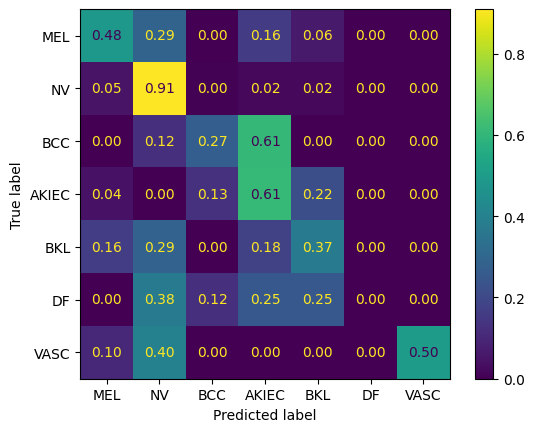

===============Fold-1 Model-> best_model_fold1.pth==================


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         MEL       0.43      0.48      0.46        62
          NV       0.91      0.91      0.91       541
         BCC       0.60      0.27      0.37        33
       AKIEC       0.20      0.61      0.30        23
         BKL       0.55      0.37      0.44        73
          DF       0.00      0.00      0.00         8
        VASC       1.00      0.50      0.67        10

    accuracy                           0.77       750
   macro avg       0.53      0.45      0.45       750
weighted avg       0.79      0.77      0.77       750

AUC of class MEL = 0.9041635408852213
AUC of class NV = 0.9323952630694532
AUC of class BCC = 0.9581589958158996
AUC of class AKIEC = 0.9429459960528677
AUC of class BKL = 0.8696707877218187
AUC of class DF = 0.9491239892183289
AUC of class VASC = 0.9898648648648649


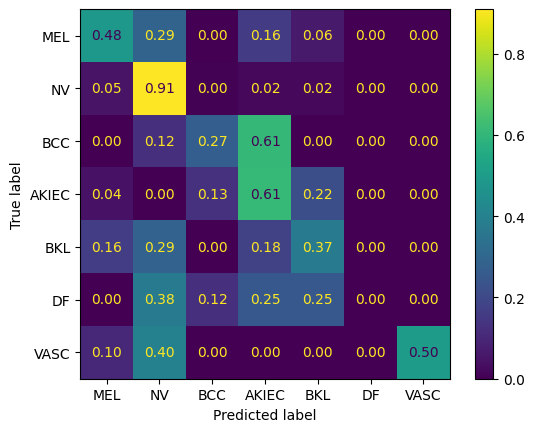

===============Fold-2 Model-> best_model_fold2.pth==================


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         MEL       0.43      0.48      0.46        62
          NV       0.91      0.91      0.91       541
         BCC       0.60      0.27      0.37        33
       AKIEC       0.20      0.61      0.30        23
         BKL       0.55      0.37      0.44        73
          DF       0.00      0.00      0.00         8
        VASC       1.00      0.50      0.67        10

    accuracy                           0.77       750
   macro avg       0.53      0.45      0.45       750
weighted avg       0.79      0.77      0.77       750

AUC of class MEL = 0.9041635408852213
AUC of class NV = 0.9323952630694532
AUC of class BCC = 0.9581589958158996
AUC of class AKIEC = 0.9429459960528677
AUC of class BKL = 0.8696707877218187
AUC of class DF = 0.9491239892183289
AUC of class VASC = 0.9898648648648649


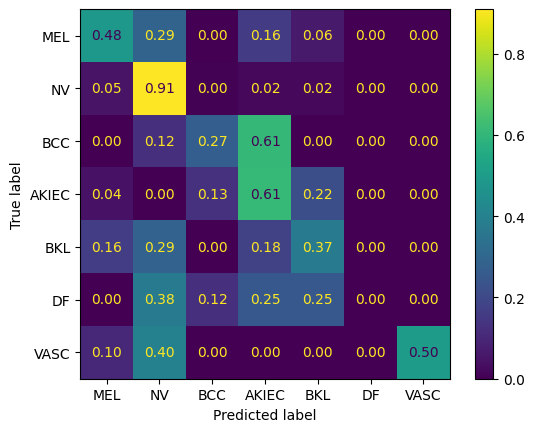

===============Fold-3 Model-> best_model_fold3.pth==================


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         MEL       0.43      0.48      0.46        62
          NV       0.91      0.91      0.91       541
         BCC       0.60      0.27      0.37        33
       AKIEC       0.20      0.61      0.30        23
         BKL       0.55      0.37      0.44        73
          DF       0.00      0.00      0.00         8
        VASC       1.00      0.50      0.67        10

    accuracy                           0.77       750
   macro avg       0.53      0.45      0.45       750
weighted avg       0.79      0.77      0.77       750

AUC of class MEL = 0.9041635408852213
AUC of class NV = 0.9323952630694532
AUC of class BCC = 0.9581589958158996
AUC of class AKIEC = 0.9429459960528677
AUC of class BKL = 0.8696707877218187
AUC of class DF = 0.9491239892183289
AUC of class VASC = 0.9898648648648649


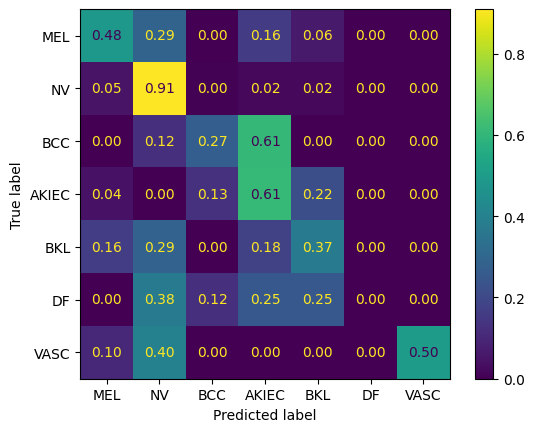

===============Fold-4 Model-> best_model_fold4.pth==================


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         MEL       0.43      0.48      0.46        62
          NV       0.91      0.91      0.91       541
         BCC       0.60      0.27      0.37        33
       AKIEC       0.20      0.61      0.30        23
         BKL       0.55      0.37      0.44        73
          DF       0.00      0.00      0.00         8
        VASC       1.00      0.50      0.67        10

    accuracy                           0.77       750
   macro avg       0.53      0.45      0.45       750
weighted avg       0.79      0.77      0.77       750

AUC of class MEL = 0.9041635408852213
AUC of class NV = 0.9323952630694532
AUC of class BCC = 0.9581589958158996
AUC of class AKIEC = 0.9429459960528677
AUC of class BKL = 0.8696707877218187
AUC of class DF = 0.9491239892183289
AUC of class VASC = 0.9898648648648649


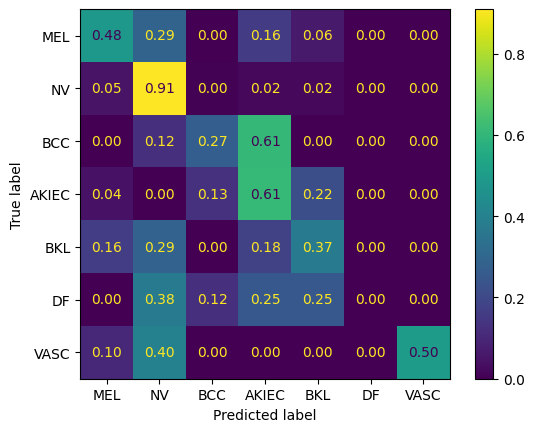

In [42]:
num_classes = 7

device = 'cuda'

model1 = torchvision.models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1').to(device)

model1.fc = nn.Linear(2048, 7).to(device)

for fold_id, mdle in enumerate(SavedModels):
    print(f'===============Fold-{fold_id} Model-> {mdle}==================')
    
    # load the last checkpoint with the best model
    model1.load_state_dict(torch.load(f'/kaggle/working/skin_models/{mdle}'))   

    predlist = torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist = torch.zeros(0,dtype=torch.long, device='cpu')
    predlistauc = torch.zeros(0,dtype=torch.long, device='cpu')
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            model1.eval()
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    #         print(preds)

            # Append batch prediction results
            predlist=torch.cat([predlist,preds.view(-1).cpu()])
            lbllist=torch.cat([lbllist,classes.view(-1).cpu()])
            predlistauc = torch.cat([predlistauc,nn.functional.softmax(outputs, dim=1).cpu()])
    predlist = predlist.numpy()
    lbllist = lbllist.numpy()
    predlistauc = predlistauc.numpy()

    # Confusion matrix, classification report
    conf_mat=confusion_matrix(lbllist, predlist)
    target_names = ['MEL','NV','BCC','AKIEC','BKL','DF','VASC',]
    cm_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    print(classification_report(lbllist, predlist, target_names=target_names))
    
    lbllist_one_hot = nn.functional.one_hot(torch.tensor([lbllist]), num_classes=num_classes)
    every_auc = roc_auc_score(lbllist_one_hot.view([predlistauc.shape[0], predlistauc.shape[1]]), 
                                              predlistauc, multi_class='ovr', average=None)
    for i, every in enumerate(target_names):
        print(f'AUC of class {every} = {every_auc[i]}')
        
    disp = ConfusionMatrixDisplay(cm_normalized, display_labels=target_names)
    disp.plot(values_format=".2f")
    plt.show()

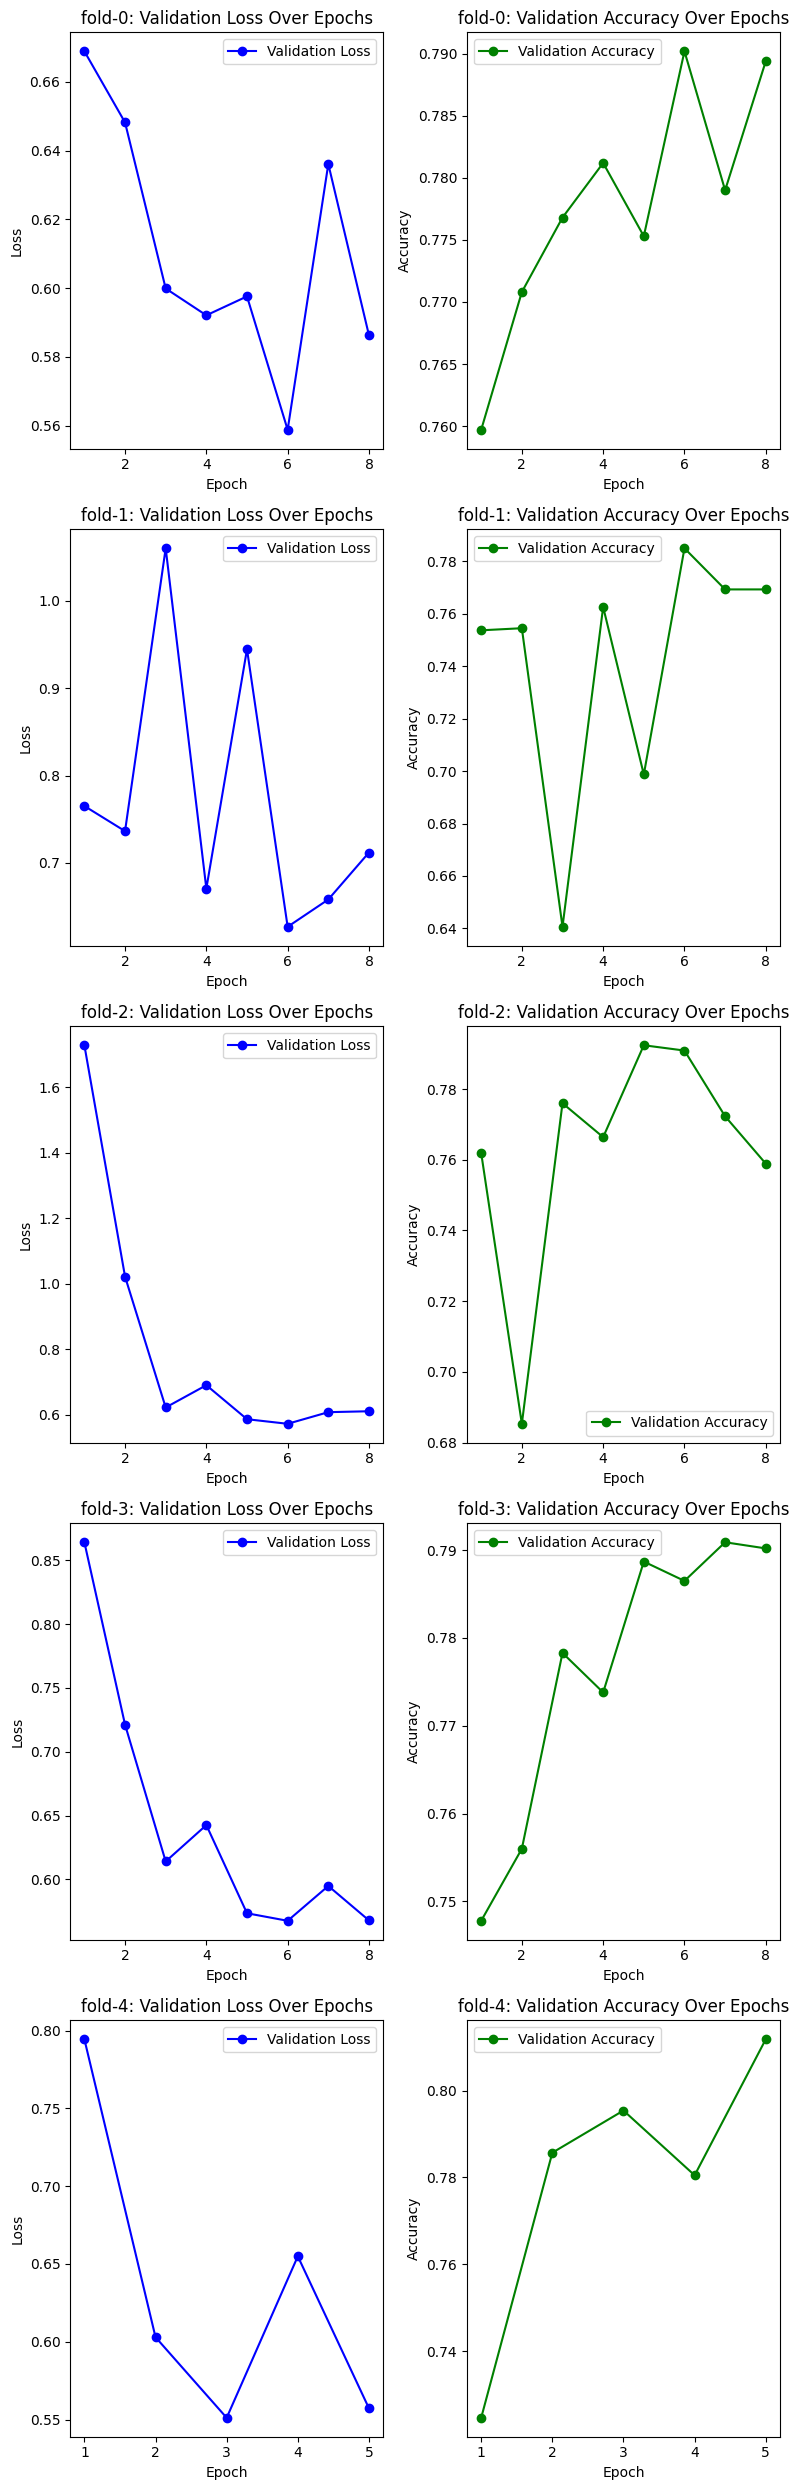

In [43]:
# Assuming you have extracted validation loss and accuracy for each model from MODEL_RESULTS
num_models = 5  # Number of models in MODEL_RESULTS

# Plot validation loss and accuracy for each model using subplots
plt.figure(figsize=(8, 5 * num_models))

for i in range(num_models):
    model_name = i
    val_loss = [float(i) for i in MODEL_RESULTS[model_name]['val_loss']]
    val_accuracy = MODEL_RESULTS[model_name]['val_acc']
    epochs = range(1, len(val_loss) + 1)

    # Subplot for validation loss
    plt.subplot(num_models, 2, 2*i + 1)  # num_models rows, 2 columns, 1st subplot for current model
    plt.plot(epochs, val_loss, 'bo-', label='Validation Loss')
    plt.title(f'fold-{model_name}: Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Subplot for validation accuracy
    plt.subplot(num_models, 2, 2*i + 2)  # num_models rows, 2 columns, 2nd subplot for current model
    plt.plot(epochs, val_accuracy, 'go-', label='Validation Accuracy')
    plt.title(f'fold-{model_name}: Validation Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Prediction

In [44]:
device = 'cuda'

model1 = torchvision.models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1').to(device)

model1.fc = nn.Linear(2048, 7).to(device)

# load the last checkpoint with the best model
model1.load_state_dict(torch.load('/kaggle/working/skin_models/best_model_fold4.pth'))   

<All keys matched successfully>

In [45]:
from torchvision import transforms
from PIL import Image

# train_dataset.class_to_idx
target_names = ['MEL','NV','BCC','AKIEC','BKL','DF','VASC']
image_path = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027960.jpg"

unseen_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image = Image.open(image_path).convert("RGB")
image = unseen_transforms(image)

# Reshape the image to add batch dimension
image = image.unsqueeze(0) 

with torch.no_grad():
    model1.eval()
    inputs = image.to(device)
    outputs = model1(inputs)
    _, preds = torch.max(outputs, 1)
    print(target_names[preds[0].item()])

BKL
